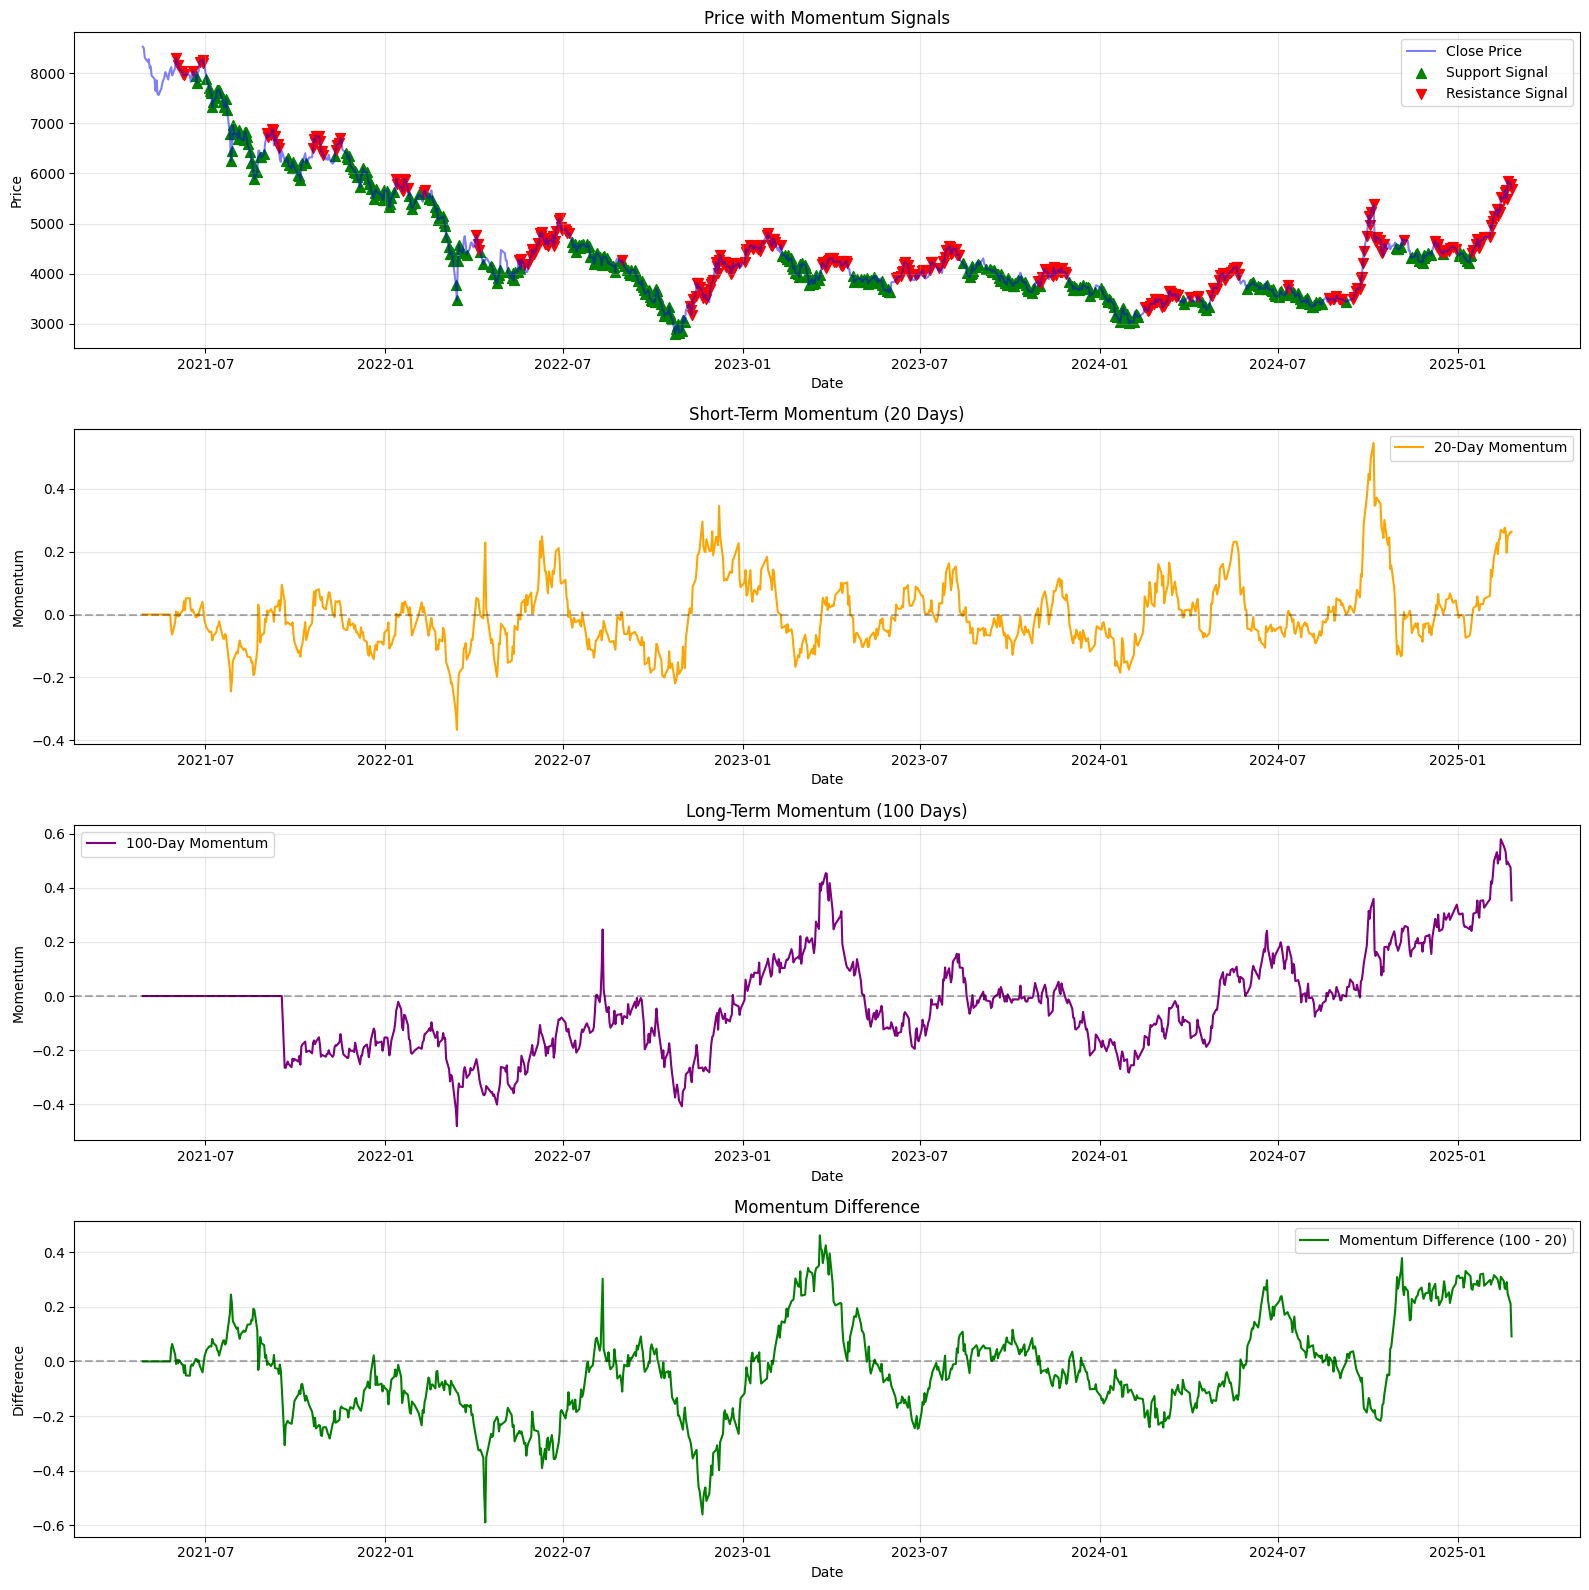

Support Win Rate: 56.98% (Signals: 444)
Resistance Win Rate: 64.78% (Signals: 318)


In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# 假设已有 ATR 和 get_future_range_numba 函数
def ATR(high, low, close, period=14):
    tr = pd.DataFrame(index=high.index)
    tr['HL'] = high - low
    tr['HC'] = abs(high - close.shift(1))
    tr['LC'] = abs(low - close.shift(1))
    tr['TR'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    return tr['TR'].rolling(window=int(period), min_periods=1).mean()

@njit
def get_future_range_numba(series, look_ahead, is_high=True):
    future_values = np.full(len(series), np.nan)
    for i in range(len(series) - look_ahead):
        if is_high:
            future_values[i] = np.max(series[i+1:i+1+look_ahead])
        else:
            future_values[i] = np.min(series[i+1:i+1+look_ahead])
    return future_values

# 数据文件路径
data_dir = '../data'
csv_filename = 'data_HK_800700_20250225.csv'
csv_path = os.path.join(data_dir, csv_filename)
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

# 计算动量
def calculate_momentum(df, window_short=20, window_long=100):
    momentum_short = (df['close'] / df['close'].shift(window_short) - 1).fillna(0)
    momentum_long = (df['close'] / df['close'].shift(window_long) - 1).fillna(0)
    momentum_diff = momentum_long - momentum_short
    return momentum_short, momentum_long, momentum_diff

momentum_short, momentum_long, momentum_diff = calculate_momentum(df)

# 生成信号（简化为示例，与 KD 类似）
def generate_signals(df, momentum_short, momentum_long, look_ahead=10, target_multiplier=1.0, atr_period=20):
    df = df.copy()
    atr = ATR(df['high'], df['low'], df['close'], period=atr_period)
    df['support_target'] = df['close'] + atr * target_multiplier
    df['resistance_target'] = df['close'] - atr * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)
    
    df['support_condition'] = (df['close'] < df['close'].rolling(20).mean()) & (momentum_short < 0)
    df['resistance_condition'] = (df['close'] > df['close'].rolling(20).mean()) & (momentum_short > 0)
    df['reversal'] = np.select(
        [df['support_condition'], df['resistance_condition']],
        ['support reversal', 'resistance reversal'],
        default='none'
    )
    
    df['support_win'] = (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']).astype(int)
    df['resistance_win'] = (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']).astype(int)
    return df

df_with_signals = generate_signals(df, momentum_short, momentum_long, look_ahead=10, target_multiplier=1.0, atr_period=20)

# 绘制图表
plt.figure(figsize=(16, 16))

# 主图：收盘价 + 信号
plt.subplot(4, 1, 1)
plt.plot(df.index, df['close'], label='Close Price', color='blue', alpha=0.5)
support_signals = df_with_signals[df_with_signals['reversal'] == 'support reversal']
resistance_signals = df_with_signals[df_with_signals['reversal'] == 'resistance reversal']
plt.scatter(support_signals.index, support_signals['close'], color='green', label='Support Signal', marker='^', s=50)
plt.scatter(resistance_signals.index, resistance_signals['close'], color='red', label='Resistance Signal', marker='v', s=50)
plt.title('Price with Momentum Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图 1：短期动量 (20 日)
plt.subplot(4, 1, 2)
plt.plot(df.index, momentum_short, label='20-Day Momentum', color='orange')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Short-Term Momentum (20 Days)')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图 2：长期动量 (100 日)
plt.subplot(4, 1, 3)
plt.plot(df.index, momentum_long, label='100-Day Momentum', color='purple')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Long-Term Momentum (100 Days)')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图 3：动量差异
plt.subplot(4, 1, 4)
plt.plot(df.index, momentum_diff, label='Momentum Difference (100 - 20)', color='green')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Momentum Difference')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 简单性能评估
def evaluate_performance(df):
    support_signals = df[df['reversal'] == 'support reversal']
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    print(f"Support Win Rate: {support_win_rate:.2%} (Signals: {len(support_signals)})")
    print(f"Resistance Win Rate: {resistance_win_rate:.2%} (Signals: {len(resistance_signals)})")

evaluate_performance(df_with_signals)

In [39]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os

# 1. 读取所有CSV文件
data_dir = '../data'  # 替换为你的CSV文件目录
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
results = {}

for file in csv_files:
    code = '_'.join(file.split('_')[1:3])  # 从文件名提取code
    df = pd.read_csv(os.path.join(data_dir, file),index_col=0, parse_dates=True)
    if 'time_key' in df.columns: # 列存在
        df['time_key'] = df['time_key'].dt.tz_localize(None)
        df.set_index(pd.DatetimeIndex(df['time_key']), inplace=True)
    else:
        df['time_key'] = df.index
    results[code] = df

# 2. 定义动量计算函数
def calculate_momentum(df, window=60, atr_window=14, future_window=21):
    df['Std_Momentum'] = (df['close'].shift(future_window) / df['close'].shift(window + future_window) - 1) * 100
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=atr_window, min_periods=1).mean()
    df['Adj_Momentum'] = df['Std_Momentum'] / df['ATR']
    df['Future_Return'] = (df['close'].shift(-future_window) / df['close'] - 1) * 100
    return df

# 3. 计算动量
for code in results:
    results[code] = calculate_momentum(results[code], window=60, future_window=21)

# 4. 分组函数
def group_by_market(code):
    if code.startswith('SH_'):
        return 'A股'
    elif code.startswith('SZ_'):
        return 'A股'
    elif code.startswith('HK_'):
        return '港股'
    elif code.startswith('US_'):
        return '美股'
    elif code.endswith('_XSHE') or code.endswith('_XSHG'):
        return 'A股'
    return '未知'

# 5. 多标的动量与未来回报相关性（按市场分组）
correlation_results = pd.DataFrame(columns=['Code', 'Std_Corr', 'Adj_Corr'])
for code in results:
    df = results[code].iloc[-60-21:-21].dropna()
    if not df.empty and len(df) >= 2:
        std_corr = df['Std_Momentum'].corr(df['Future_Return'])
        adj_corr = df['Adj_Momentum'].corr(df['Future_Return'])
        if not pd.isna(std_corr) and not pd.isna(adj_corr):
            correlation_results = pd.concat([correlation_results, pd.DataFrame({
                'Code': [code],
                'Std_Corr': [std_corr],
                'Adj_Corr': [adj_corr]
            })], ignore_index=True)

# 添加市场分组列
correlation_results['Market'] = correlation_results['Code'].apply(group_by_market)

# 6. 按市场输出相关性
markets = correlation_results['Market'].unique()
for market in markets:
    market_data = correlation_results[correlation_results['Market'] == market]
    print(f"\n市场: {market}")
    print(market_data[['Code', 'Std_Corr', 'Adj_Corr']])
    print(f"平均标准动量相关性: {market_data['Std_Corr'].mean():.3f}")
    print(f"平均调整动量相关性: {market_data['Adj_Corr'].mean():.3f}")

# 7. 多标的对比（最新数据，含归一化，按市场排序）
comparison = pd.DataFrame()
for code in results:
    latest = results[code].iloc[-1]
    comparison = pd.concat([comparison, pd.DataFrame({
        'code': [code],
        'Std_Momentum': [latest['Std_Momentum']],
        'Adj_Momentum': [latest['Adj_Momentum']]
    })], ignore_index=True)

comparison['Adj_Momentum_Norm'] = (comparison['Adj_Momentum'] - comparison['Adj_Momentum'].mean()) / comparison['Adj_Momentum'].std()
comparison['Market'] = comparison['code'].apply(group_by_market)
comparison.set_index('code', inplace=True)

for market in markets:
    print(f"\n市场: {market} - 多标的对比（最新数据）：")
    print(comparison[comparison['Market'] == market][['Std_Momentum', 'Adj_Momentum', 'Adj_Momentum_Norm']])


市场: A股
           Code  Std_Corr  Adj_Corr
0   000001_XSHG -0.132598 -0.162799
1   159869_XSHE  0.115148  0.344820
2   159995_XSHE  0.252506  0.211002
5     SH_000001  0.017602 -0.036067
6     SH_000902  0.028935  0.033401
7     SH_000922 -0.123760 -0.243379
8     SH_510300  0.062897  0.135528
9     SH_510880 -0.211644 -0.271734
10    SH_512010  0.011949  0.155816
11    SH_512200 -0.297589  0.002176
12    SH_512400  0.229736  0.441512
13    SH_512660  0.063148  0.042534
14    SH_512690 -0.136945 -0.034227
15    SH_512800  0.121117  0.139455
16    SH_512880 -0.451160 -0.229022
17    SH_513360  0.445183  0.664770
18    SH_513630  0.484714  0.408430
19    SH_515030 -0.028900  0.270393
20    SH_515170 -0.248672 -0.168548
21    SH_515210  0.109630  0.273763
22    SH_515220 -0.381500 -0.377694
23    SH_515230  0.128623  0.271318
24    SH_515790 -0.177605  0.091302
25    SH_516970  0.176366  0.160942
26    SH_588200  0.108692  0.086352
27    SZ_159611  0.153816  0.180524
28    SZ_159732  0.4

C:\Users\wzzha\AppData\Local\Temp\ipykernel_36300\2498634867.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_results = pd.concat([correlation_results, pd.DataFrame({
